## Traffic Accident Analysis & Prediction

## DATA LOADING & CLEANING

In [1]:
import pandas as pd
import numpy as np
import os

# Load the LA traffic accident dataset
df = pd.read_csv("traffic_collision.csv")
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'])
df['Hour'] = df['Time Occurred'] // 100
df['Day'] = df['Date Occurred'].dt.dayofweek

# Extraction latitude and longitude from Location field
df['Latitude'] = df['Location'].str.extract(r"'latitude': '(-?\d+\.\d+)'").astype(float)
df['Longitude'] = df['Location'].str.extract(r"'longitude': '(-?\d+\.\d+)'").astype(float)

# Remove null values
df = df.dropna(subset=['Latitude', 'Longitude'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502858 entries, 0 to 502857
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   DR Number                          502858 non-null  int64         
 1   Date Reported                      502858 non-null  object        
 2   Date Occurred                      502858 non-null  datetime64[ns]
 3   Time Occurred                      502858 non-null  int64         
 4   Area ID                            502858 non-null  int64         
 5   Area Name                          502858 non-null  object        
 6   Reporting District                 502858 non-null  int64         
 7   Crime Code                         502858 non-null  int64         
 8   Crime Code Description             502858 non-null  object        
 9   MO Codes                           416597 non-null  object        
 10  Victim Age          

In [2]:
df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),Hour,Day,Latitude,Longitude
0,191323054,2019-11-30T00:00:00.000,2019-11-30,130,13,Newton,1385,997,TRAFFIC COLLISION,NaN,...,22352.0,786.0,858.0,7.0,13.0,46.0,1,5,33.9885,-118.2696
1,192020666,2019-11-30T00:00:00.000,2019-11-30,15,20,Olympic,2054,997,TRAFFIC COLLISION,NaN,...,22723.0,617.0,646.0,NaN,12.0,89.0,0,5,34.0526,-118.3031
2,191616992,2019-11-30T00:00:00.000,2019-11-30,230,16,Foothill,1669,997,TRAFFIC COLLISION,NaN,...,3222.0,5.0,227.0,NaN,1.0,7.0,2,5,34.2339,-118.2704
3,191824082,2019-11-30T00:00:00.000,2019-11-30,730,18,Southeast,1802,997,TRAFFIC COLLISION,0605,...,22352.0,800.0,358.0,7.0,14.0,45.0,7,5,33.9572,-118.2739
4,191616980,2019-11-30T00:00:00.000,2019-11-30,720,16,Foothill,1689,997,TRAFFIC COLLISION,NaN,...,19335.0,166.0,272.0,NaN,3.0,21.0,7,5,34.2215,-118.3703


## VISUALIZATION

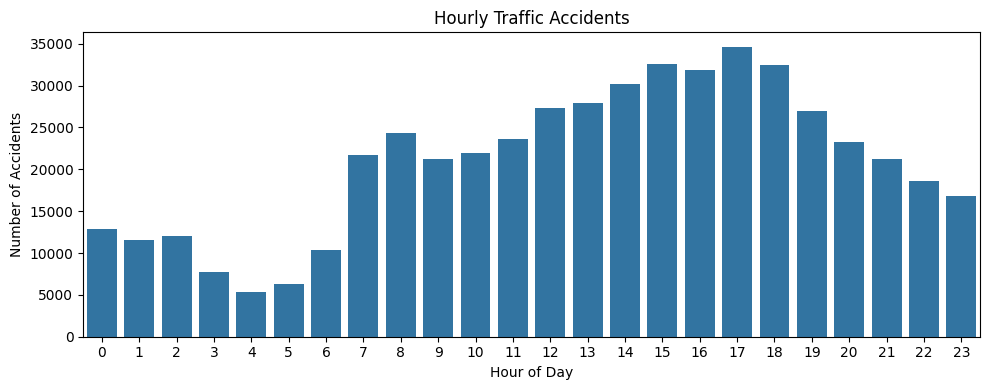

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Create output directory if not exists
os.makedirs("outputs", exist_ok=True)

# Hourly trend plot
plt.figure(figsize=(10, 4))
sns.countplot(x='Hour', data=df)
plt.title("Hourly Traffic Accidents")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.savefig("outputs/hourly_accidents.png")
plt.show()
plt.close()

# Heatmap of accidents
m = folium.Map(location=[34.05, -118.24], zoom_start=10)
HeatMap(df[['Latitude', 'Longitude']].values, radius=6).add_to(m)
m.save("outputs/accident_heatmap.html")

## TRAIN-TEST SPLIT WITH NEGATIVE SAMPLING

In [3]:
from sklearn.model_selection import train_test_split

# Bin locations for positive samples (accidents)
df['LatBin'] = (df['Latitude'] * 10).round()
df['LonBin'] = (df['Longitude'] * 10).round()
df['Label'] = 1  # accident

# Generate negative samples (no accident)
num_neg_samples = len(df)

# Random lat/lon within LA area approx
neg_lat = np.random.uniform(33.5, 34.5, size=num_neg_samples)
neg_lon = np.random.uniform(-119, -117.5, size=num_neg_samples)
neg_hour = np.random.randint(0, 24, size=num_neg_samples)
neg_day = np.random.randint(0, 7, size=num_neg_samples)

neg_df = pd.DataFrame({
    'Hour': neg_hour,
    'Day': neg_day,
    'LatBin': np.round(neg_lat * 10),
    'LonBin': np.round(neg_lon * 10),
    'Label': 0  # no accident
})

# Combine positive and negative samples
full_df = pd.concat([
    df[['Hour', 'Day', 'LatBin', 'LonBin', 'Label']],
    neg_df
], ignore_index=True)

features = full_df[['Hour', 'Day', 'LatBin', 'LonBin']]
labels = full_df['Label']

# train-test split to keep label distribution balanced
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels
)

print("Training data label counts:\n", y_train.value_counts())
print("Testing data label counts:\n", y_test.value_counts())

Training data label counts:
 Label
1    352001
0    352000
Name: count, dtype: int64
Testing data label counts:
 Label
0    150858
1    150857
Name: count, dtype: int64


##  MODEL TRAINING

In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## EVALUATION

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    150858
           1       0.90      0.98      0.93    150857

    accuracy                           0.93    301715
   macro avg       0.94      0.93      0.93    301715
weighted avg       0.94      0.93      0.93    301715



## saving the model

In [6]:
from joblib import dump,load
dump(load,'t_accident_pred.joblib')

['t_accident_pred.joblib']